In [1]:
# Load NeuroKit and other useful packages
#%matplotlib widget


import neurokit2 as nk

import numpy as np 
import pandas as pd
import os

import csv
import itertools
import collections
import pywt

from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

In [3]:
path = '../Fractal Analysis//mitbih_database/'
window_size = 1800
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [4]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()



In [5]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

In [6]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
        
    signals = denoise(signals)
        
    signals = stats.zscore(signals)
    #signals = remove_baseline_wander(signals, sample_rate = 360.0)
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ') #The split() method splits a string into a list.
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
           # if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
                #    pass
            #else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]  
                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))

(99507, 3600) (99507,)


In [7]:
norm    = []
lbbb    = []
rbbb    = []
pac     = []
pvc     = []

for i in range(len(X)):
    if y[i] == 0:
        norm.append(X[i])
    elif y[i] == 1:
        lbbb.append(X[i])
    elif y[i] == 2:
        rbbb.append(X[i])
    elif y[i] == 3:
        pac.append(X[i])
    elif y[i] == 4:
        pvc.append(X[i])

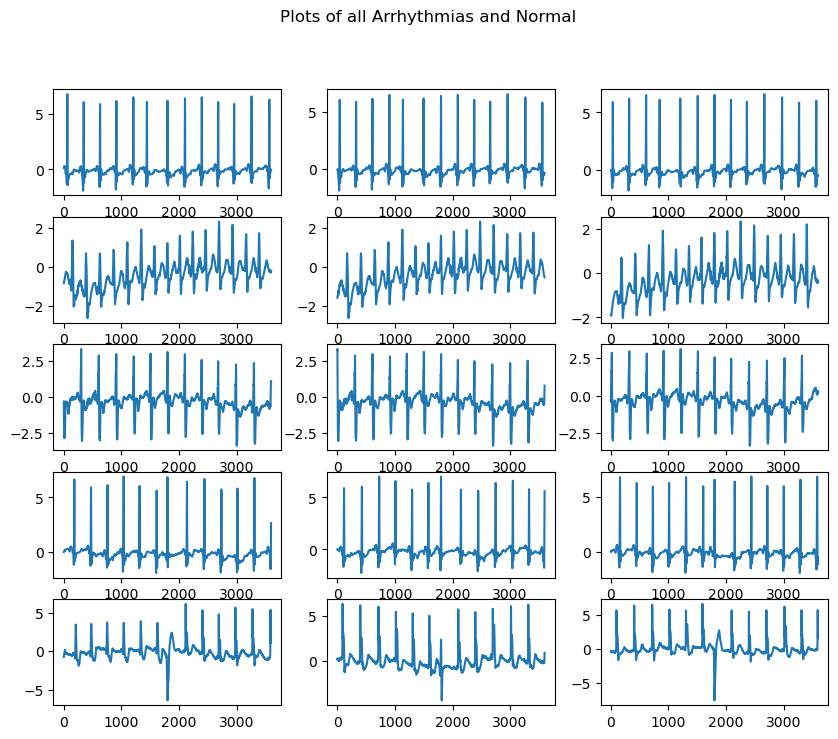

In [8]:
plt.figure(figsize=(10,8))

plt.suptitle("Plots of all Arrhythmias and Normal")
plt.subplot(5,3,1)
plt.plot(norm[1])
plt.subplot(5,3,2)
plt.plot(norm[2])
plt.subplot(5,3,3)
plt.plot(norm[3])

plt.subplot(5,3,4)
plt.plot(lbbb[1])
plt.subplot(5,3,5)
plt.plot(lbbb[2])
plt.subplot(5,3,6)
plt.plot(lbbb[3])

plt.subplot(5,3,7)
plt.plot(rbbb[1])
plt.subplot(5,3,8)
plt.plot(rbbb[2])
plt.subplot(5,3,9)
plt.plot(rbbb[3])

plt.subplot(5,3,10)
plt.plot(pac[1])
plt.subplot(5,3,11)
plt.plot(pac[2])
plt.subplot(5,3,12)
plt.plot(pac[3])

plt.subplot(5,3,13)
plt.plot(pvc[1])
plt.subplot(5,3,14)
plt.plot(pvc[2])
plt.subplot(5,3,15)
plt.plot(pvc[3])




In [9]:
from numpy.lib.stride_tricks import sliding_window_view

window_signal1 = sliding_window_view(norm[1], window_shape = 360)
window_signal2 = sliding_window_view(lbbb[1], window_shape = 360)
window_signal3 = sliding_window_view(rbbb[1], window_shape = 360)
window_signal4 = sliding_window_view(pac[1], window_shape = 360)
window_signal5 = sliding_window_view(pvc[1], window_shape = 360)

In [10]:
from hfd import hfd

rollingHFD1 = []
rollingHFD2 = []
rollingHFD3 = []
rollingHFD4 = []
n = 0
for i in range (len(window_signal1)):
    rollingHFD1.insert(n, hfd(window_signal1[i], opt = False))
    rollingHFD2.insert(n, hfd(window_signal2[i], opt = False))
    rollingHFD3.insert(n, hfd(window_signal3[i], opt = False))
    rollingHFD4.insert(n, hfd(window_signal4[i], opt = False))
    n+=1

In [11]:
rollingHFD5 = []
n = 0
for i in range (len(window_signal5)):
    rollingHFD5.insert(n, hfd(window_signal5[i], opt = False))
    n+=1

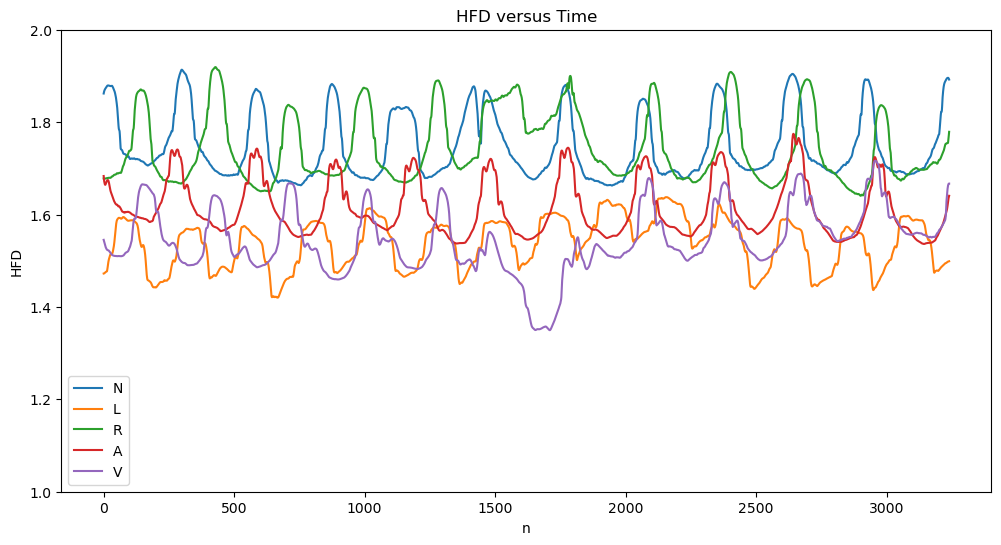

In [12]:
from cProfile import label


plt.figure(figsize=(12,6))
plt.plot(rollingHFD1, label = 'N')          
plt.plot(rollingHFD2, label = 'L')
plt.plot(rollingHFD4, label = 'R')
plt.plot(rollingHFD3, label = 'A') 
plt.plot(rollingHFD5, label = 'V') 
plt.ylim(1,2)

plt.title('HFD versus Time')
plt.xlabel('n')
plt.ylabel('HFD')
plt.legend()

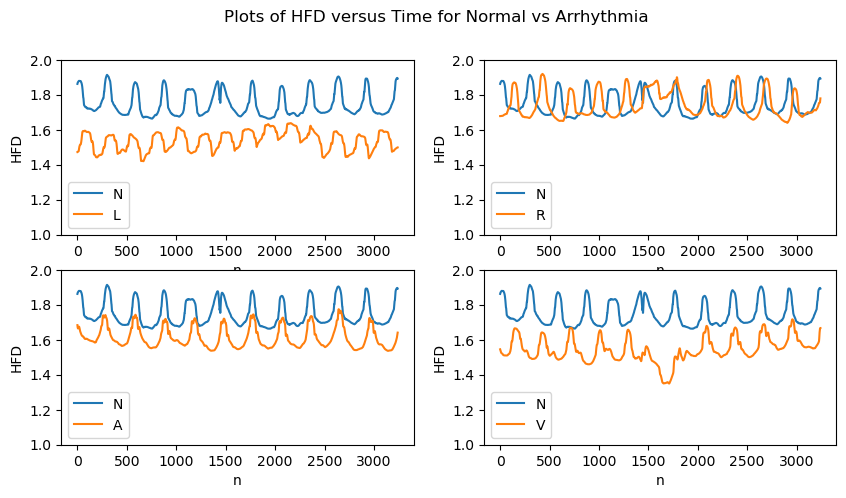

In [13]:
plt.figure(figsize=(10,5))
plt.suptitle('Plots of HFD versus Time for Normal vs Arrhythmia')
plt.subplot(2,2,1)
plt.plot(rollingHFD1, label = 'N')          
plt.plot(rollingHFD2, label = 'L')
plt.ylim(1,2)
plt.xlabel('n')
plt.ylabel('HFD')
plt.legend()

plt.subplot(2,2,2)
plt.plot(rollingHFD1, label = 'N')
plt.plot(rollingHFD4, label = 'R')
plt.ylim(1,2)
plt.xlabel('n')
plt.ylabel('HFD')
plt.legend()

plt.subplot(2,2,3)
plt.plot(rollingHFD1, label = 'N')
plt.plot(rollingHFD3, label = 'A')
plt.ylim(1,2) 
plt.xlabel('n')
plt.ylabel('HFD')
plt.legend()

plt.subplot(2,2,4)
plt.plot(rollingHFD1, label = 'N')
plt.plot(rollingHFD5, label = 'V')
plt.ylim(1,2)
plt.xlabel('n')
plt.ylabel('HFD')
plt.legend()

In [14]:
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
for i in range(len(np.array(rollingHFD5))):
    x1.append(np.mean(rollingHFD1))
    x2.append(np.mean(rollingHFD2))
    x3.append(np.mean(rollingHFD3))
    x4.append(np.mean(rollingHFD4))
    x5.append(np.mean(rollingHFD5))
    

In [20]:
print(np.mean(rollingHFD1))
print(np.mean(rollingHFD2))
print(np.mean(rollingHFD3))
print(np.mean(rollingHFD4))
print(np.mean(rollingHFD5))

1.7460414461378275
1.5383186392622072
1.6119422729852557
1.7439005375609375
1.5431054734081269


In [ ]:
s1 = []
s2 = []
s3 = []
s4 = []
s5 = []
for i in range(len(np.array(rollingHFD5))):
    s1.append(np.std(rollingHFD1))
    s2.append(np.std(rollingHFD2))
    s3.append(np.std(rollingHFD3))
    s4.append(np.std(rollingHFD4))
    s5.append(np.std(rollingHFD5))

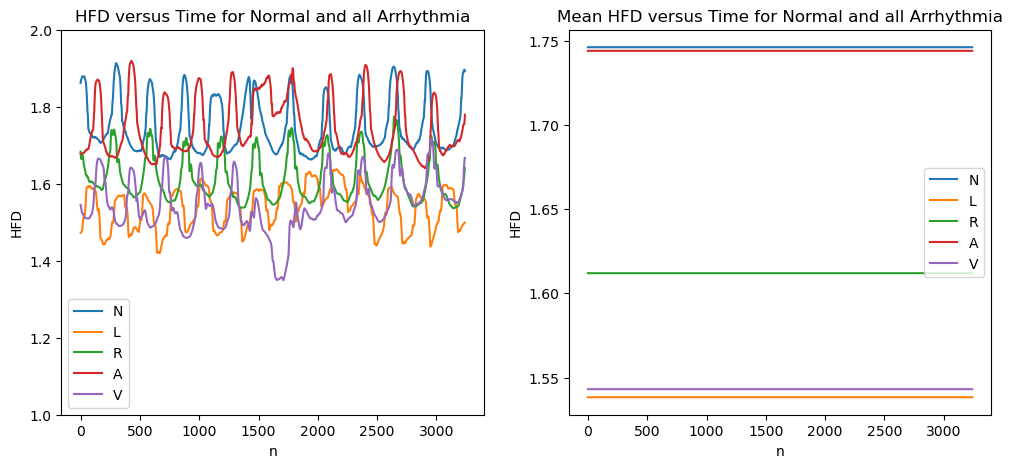

In [16]:
plt.figure(figsize=(12,5)) 

plt.subplot(1,2,1)
plt.plot(rollingHFD1, label = 'N')          
plt.plot(rollingHFD2, label = 'L')
plt.plot(rollingHFD3, label = 'R')
plt.plot(rollingHFD4, label = 'A') 
plt.plot(rollingHFD5, label = 'V') 
plt.ylim(1,2)

plt.title('HFD versus Time for Normal and all Arrhythmia')
plt.xlabel('n')
plt.ylabel('HFD')
plt.legend()

plt.subplot(1,2,2)
plt.plot(x1, label = 'N')        
plt.plot(x2, label = 'L')
plt.plot(x3, label = 'R')
plt.plot(x4, label = 'A') 
plt.plot(x5, label = 'V') 


plt.title('Mean HFD versus Time for Normal and all Arrhythmia')
plt.xlabel('n')
plt.ylabel('HFD')

plt.legend()